In [1]:
from stable_baselines3.common.env_checker import check_env
import numpy as np
import torch
import sys
import os
sys.path.append('..')


In [2]:
from stable_baselines3.common.monitor import Monitor
from Enviroments.Continuous_Env import DroneEnv
runtime = 5
dt = 0.001
env = DroneEnv(runtime = runtime, dt = dt)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

C:\Anaconda3\envs\research\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
from Algs.agent import  Agent
hidden_size = 128
batch_size = 256
# model_type = 'LSTM'
model_type = 'Transformer'
enc_path = model_type + ".pth"

model = Agent(state_size=state_size,hidden_size=hidden_size, random_seed=42,
              env = env,batch_size = batch_size,model_type=model_type)
ENC_model_check_point = torch.load(enc_path)
model.model.load_state_dict(ENC_model_check_point['model_state_dict'])
Enc = model.model


In [4]:
# print(Enc.hidden_size)
# Test_in=torch.tensor(np.ones((1,state_size,11)), dtype=torch.float32)
# print(Enc.featersExtract(Test_in).detach().numpy().shape)

In [9]:
# Test_in=torch.tensor(np.ones((1,state_size,11)), dtype=torch.float32)
# print(model.model.featersExtract(Test_in).shape)
# np.ones((1,11,state_size)).shape

from Enviroments.Continuous_Env_with_Feat import DroneEnv
log_dir = "/TmpDir/A2CFix"
os.makedirs(log_dir, exist_ok=True)

env = DroneEnv(Encoder = Enc,runtime = runtime, dt = dt)
check_env(env,warn=True)
env = Monitor(env, log_dir)
obs = env.reset()
print(env.observation_space.shape)

C:\Anaconda3\envs\research\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


(128,)


In [10]:
import torch.nn as nn
random_seed = 6
learning_rate = 2e-5
n_steps = 256
gamma = 0.99
num_of_layer = 2
hidden_size = 128
net_arc = [hidden_size] * num_of_layer
policy_kwargs = dict(net_arch=net_arc)

In [11]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

Output()

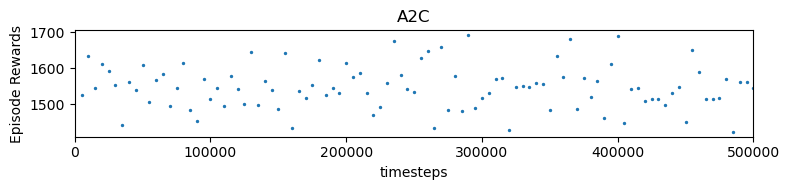

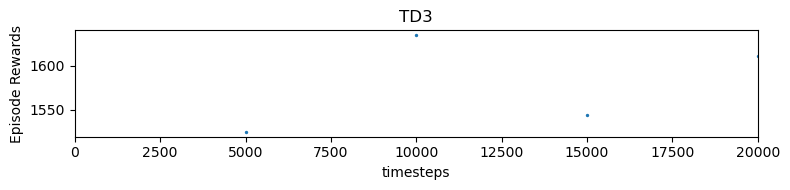

In [17]:
from stable_baselines3 import PPO, A2C,TD3,SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common import results_plotter
tensorboard_log="./Logs_tensorboard_fix/"

# vec_env = make_vec_env(lambda: env, n_envs=10)
# model = A2C('MlpPolicy', vec_env, verbose=0, seed=random_seed, learning_rate=learning_rate, n_steps=n_steps,
#                 gamma=gamma,policy_kwargs=policy_kwargs,tensorboard_log=tensorboard_log)
# model.learn(total_timesteps= 500_000,progress_bar=True)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir,verbose=0)
vec_env = make_vec_env(lambda: env, n_envs=10)
# model = SAC('MlpPolicy', vec_env, verbose=0, seed=random_seed, learning_rate=learning_rate,
#                 gamma=gamma,policy_kwargs=policy_kwargs)
# model.learn(total_timesteps=int(5e5), callback=callback,progress_bar=True)
results_plotter.plot_results([log_dir], 5e5, results_plotter.X_TIMESTEPS, "A2C")

# vec_env = make_vec_env(lambda: env, n_envs=10)
# model = PPO('MlpPolicy', vec_env, verbose=0, seed=random_seed, learning_rate=learning_rate, n_steps=n_steps,
#                 gamma=gamma,policy_kwargs=policy_kwargs)
# model.learn(total_timesteps= 200000,progress_bar=True)


model = TD3('MlpPolicy', env, verbose=0, seed=random_seed, learning_rate=learning_rate,gamma=gamma)
model.learn(total_timesteps= 200000,progress_bar=True)
results_plotter.plot_results([log_dir], 20000, results_plotter.X_TIMESTEPS, "TD3")

C:\Anaconda3\envs\research\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


reward= 9.080835342407227


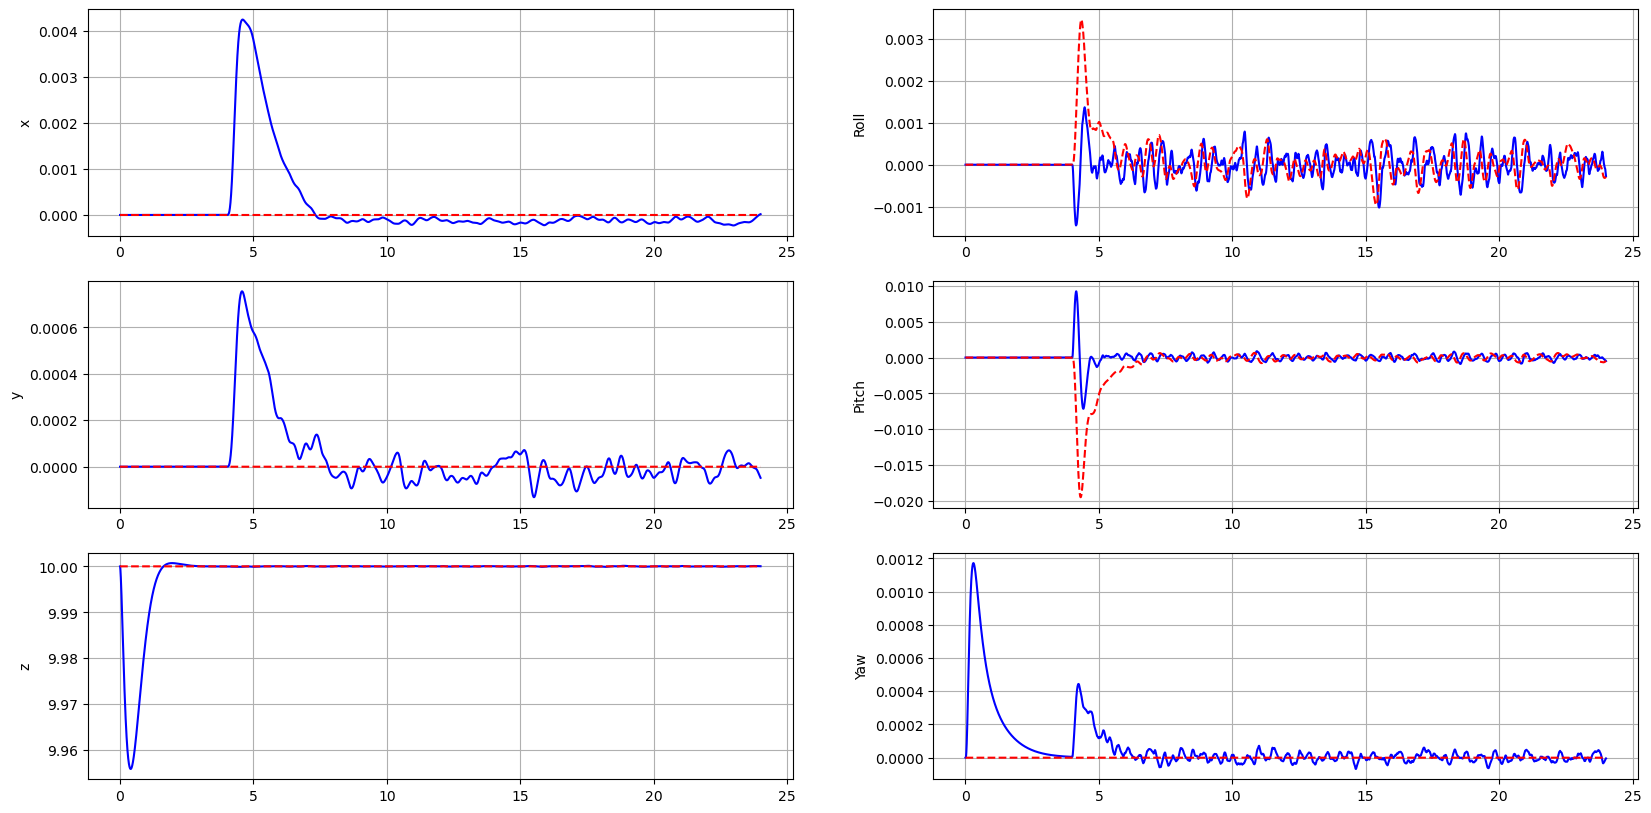

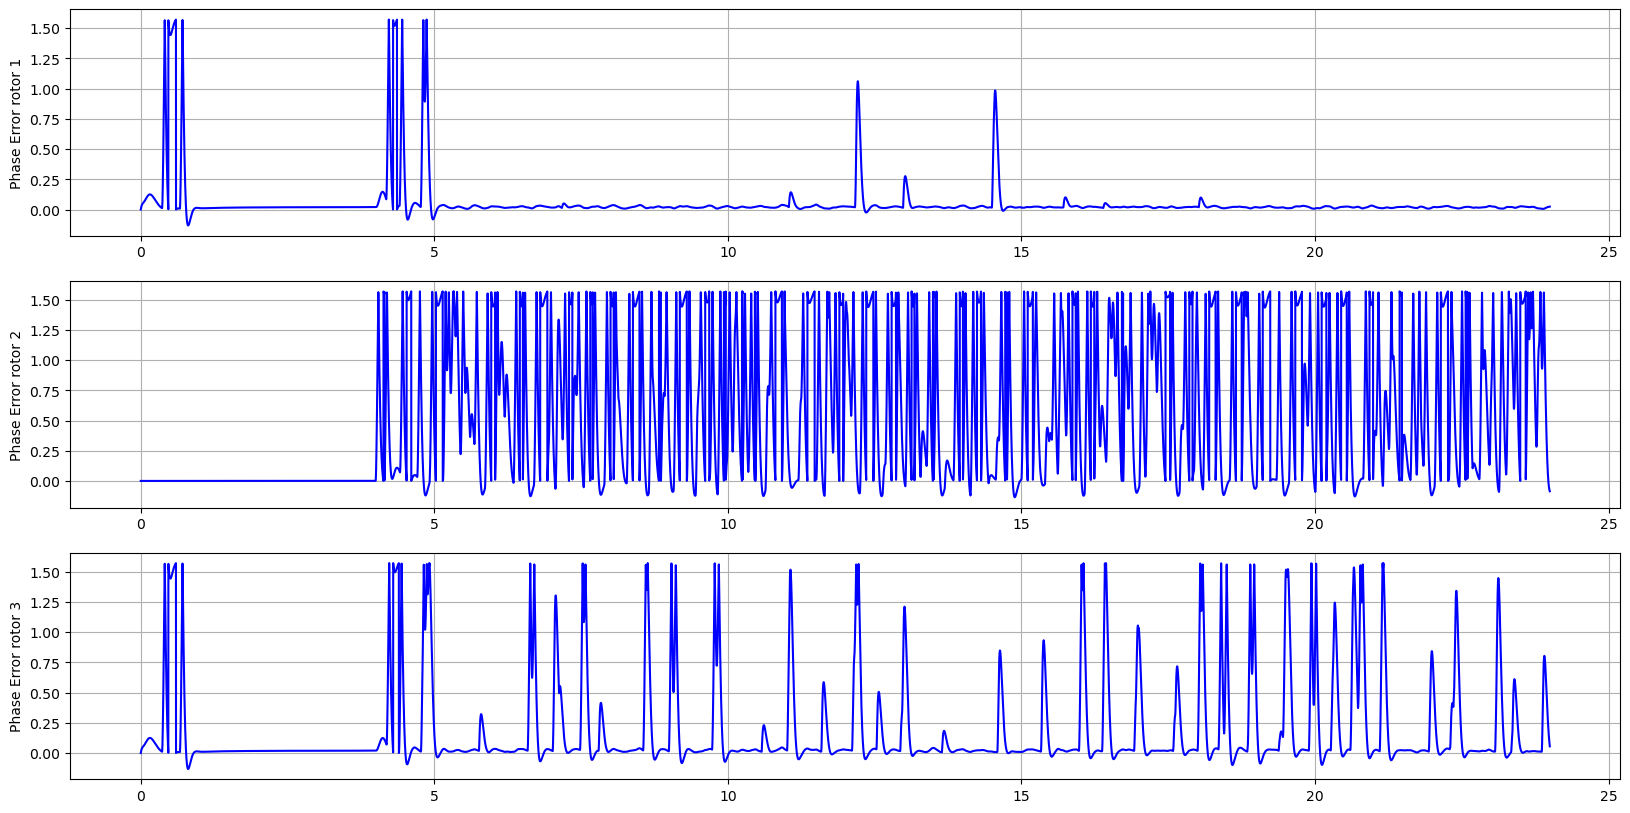

In [13]:
import matplotlib.pyplot as plt
from Physics_Models.ControlAlgTestMod import *
runtime=20
env = DroneEnv(Encoder= Enc,runtime=20., dt=0.001,)
obs = env.reset()
n_steps = runtime*1000

cmd1 =[]
cmd3 =[]
st1 = []
st3 = []
st2 = []
r = 0
rewrd =[0]
rewards = 0.
state_vec = []
action_vec = []
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    r = reward

    rewrd.append(reward)
    # state_vec.append(obs)
    action_vec.append(action)
    # st1.append(Fold2HalfPi(obs[0]*3.14)[0])
    # st2.append(Fold2HalfPi(obs[0]*3.14)[0])
    # st3.append(Fold2HalfPi(obs[0]*3.14)[0])
    if done or step == (n_steps -1):
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
        print("reward=", r)
        env.render(mode='rgb_array')
        break

# plt.plot(rewrd, 'b')
# plt.show()

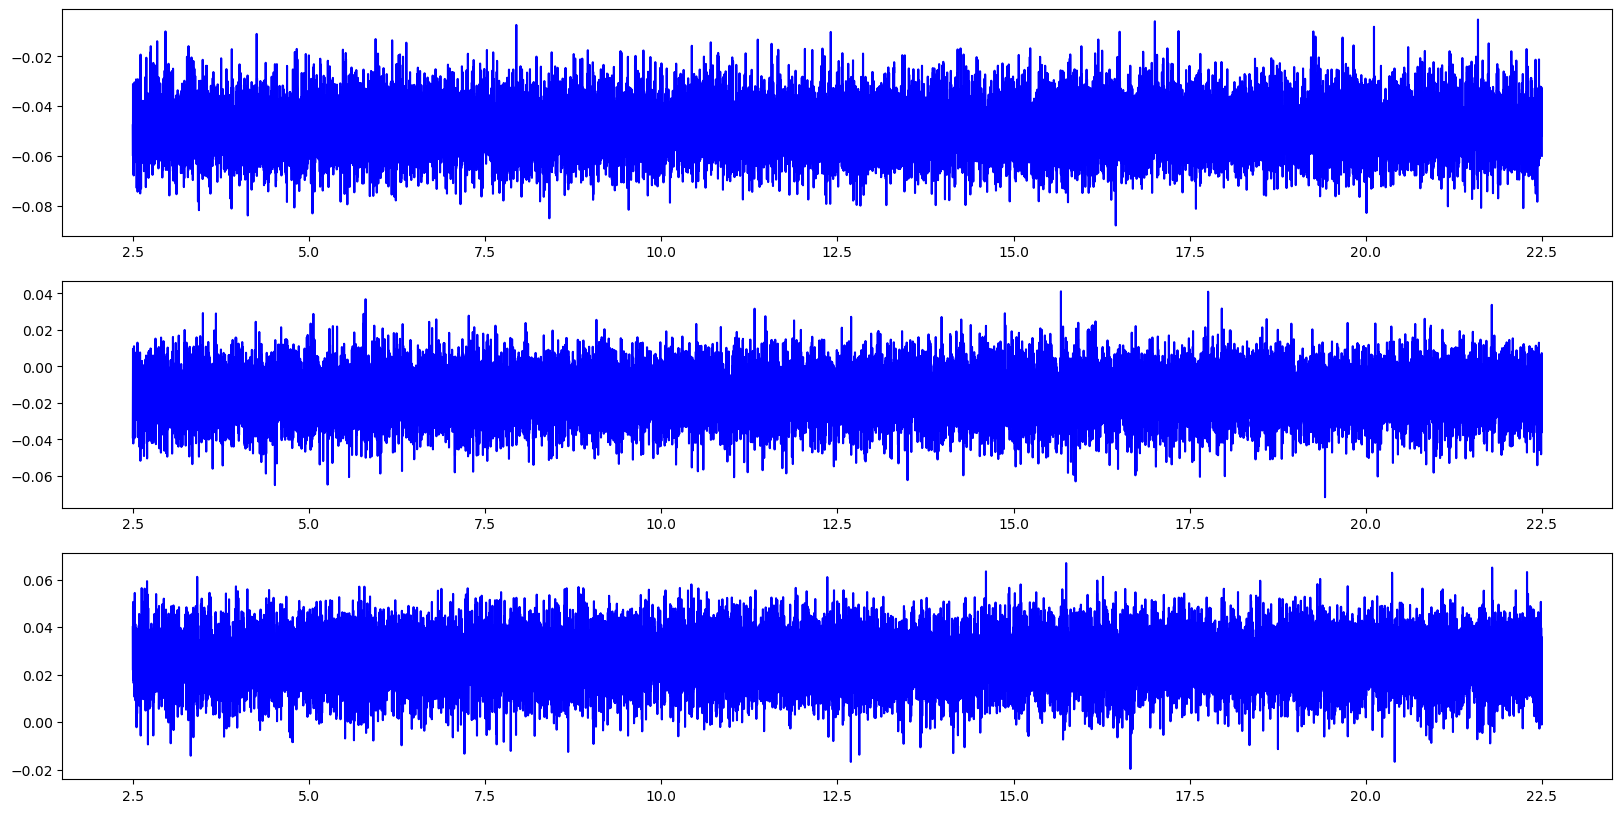

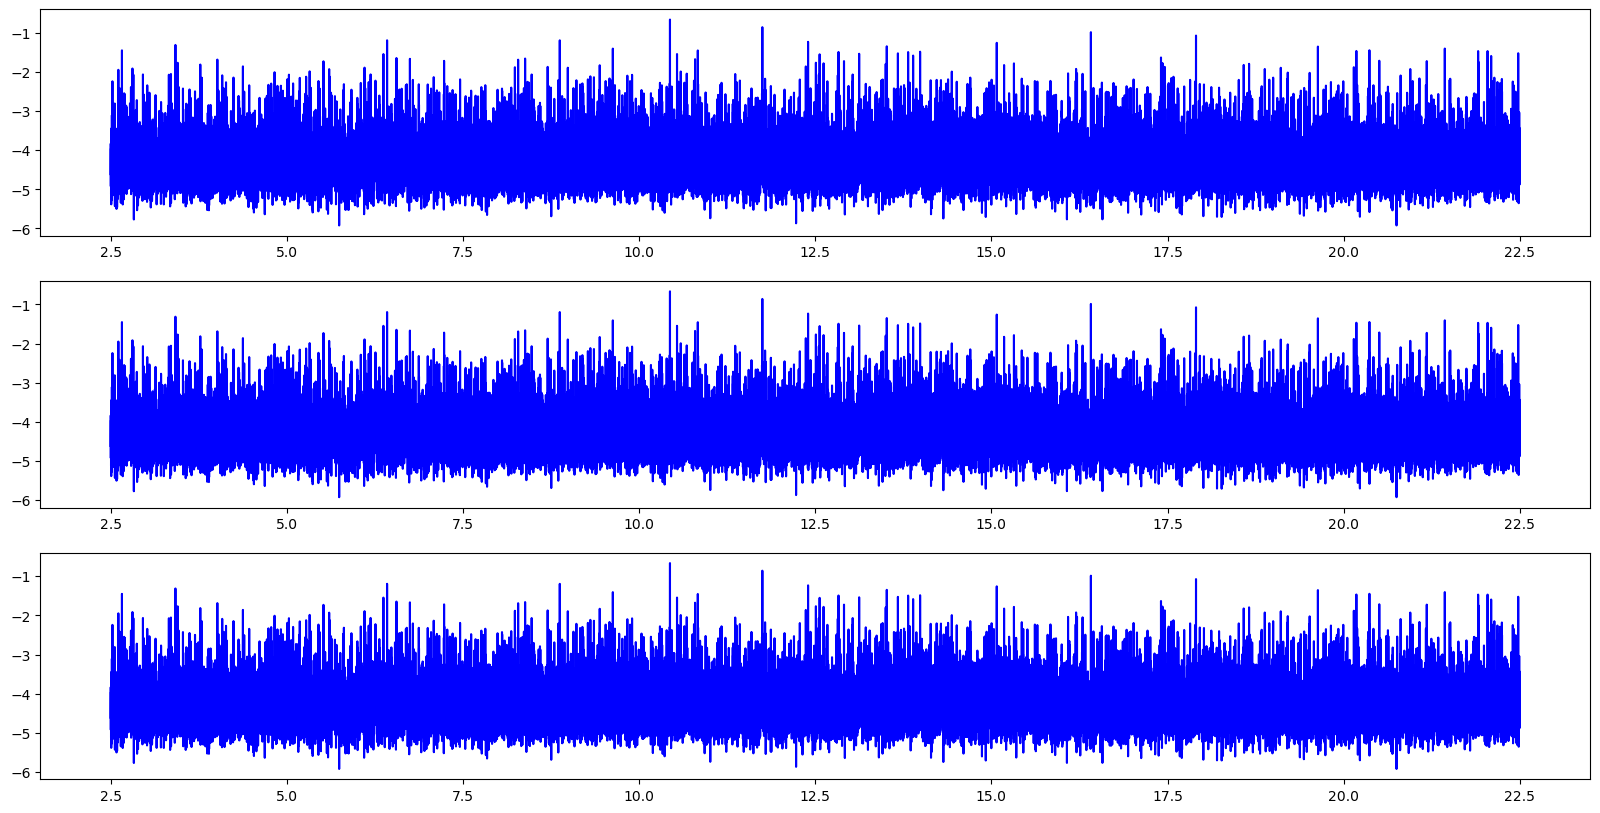

In [14]:
action_len = len(action_vec)
ACT = np.array(action_vec)
time = np.arange(len(rewrd)-1)*0.001+4
fig2, axs2 = plt.subplots(3)
fig2.set_figwidth(20)
fig2.set_figheight(10)
axs2[0].plot(time, ACT[:,0], 'b')
axs2[1].plot(time, ACT[:,1], 'b')
axs2[2].plot(time, ACT[:,2], 'b')
plt.show()
#
# fig2, axs2 = plt.subplots(3)
# fig2.set_figwidth(20)
# fig2.set_figheight(10)
# axs2[0].plot(time,st1, 'b')
# axs2[1].plot(time,st2, 'b')
# axs2[2].plot(time,st3, 'b')
# plt.show()